<a href="https://colab.research.google.com/github/Ajjme/Climate_system_modeling/blob/main/Energy_Demand_Functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code works to calculate the $/year of energy production infastructure
it works by taking GDP values from another module and converting that into the amount of infastructure needed to produce the required power. There are two main Modules Energy Reqirements and Energy Consuming capitial. They follow the same pattern of stock aging but one is capital costs and the other is energy requirements.

There are off shoots in the form of the tech effect ratio that reduces the infastructure cost by an amount due to the increase in technology

There is also the complementary assets peice which is the value of non energy generation assets that are needed and cost money so those are added to the overall cost.

The 2nd last section of the code applies the Tech adjustment ratio to the Energy requirement and Consuming Capital Array outputs.

Finally, The total yearly total cost of consuming capital is added with complementary assets to get yearly energy demand capital cost for other modules

   Year  Residential and Commercial - coal  Residential and Commercial - oil  \
0  2025                         153.794778                        422.935641   
1  2026                         148.217547                        407.598255   
2  2027                         143.007371                        393.270271   
3  2028                         137.988700                        379.468926   
4  2029                         133.049007                        365.884768   
5  2030                         128.121617                        352.334448   
6  2031                         123.172619                        338.724701   
7  2032                         118.190925                        325.025045   
8  2033                         113.180822                        311.247261   
9  2034                         108.156412                        297.430134   

   Residential and Commercial - gas  Residential and Commercial - bio  \
0                        461.384335           

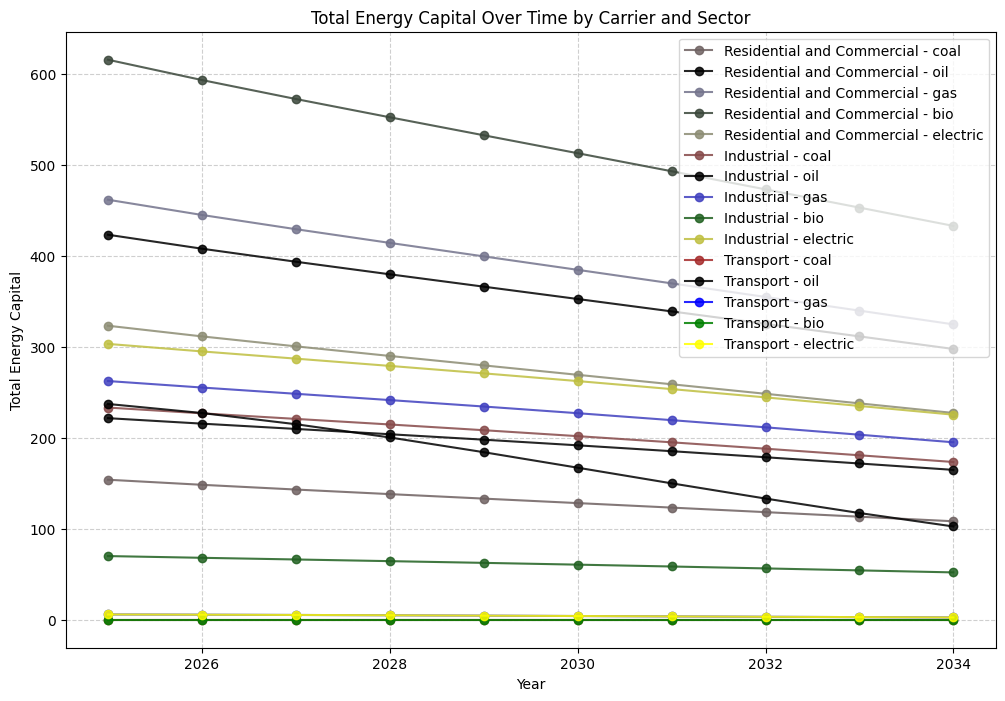

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class EnergyConsumingCapital:
    def __init__(self, sector, carrier, gdp_by_sector, gdp_growth_rate, market_prices, initial_prices):
        self.sector = sector
        self.carrier = carrier
        self.gdp_by_sector = gdp_by_sector
        self.gdp_growth_rate = gdp_growth_rate
        self.market_prices = market_prices
        self.initial_prices = initial_prices

        self.initial_capital_output_ratio = {
            "coal": {"Residential and Commercial": 2, "Industrial": 4, "Transport": 0},
            "oil": {"Residential and Commercial": 5.5, "Industrial": 3.8, "Transport": 8.2},
            "gas": {"Residential and Commercial": 6, "Industrial": 4.5, "Transport": 0.2},
            "bio": {"Residential and Commercial": 8, "Industrial": 1.2, "Transport": 0},
            "electric": {"Residential and Commercial": 4.2, "Industrial": 5.2, "Transport": 0.2},
        }[carrier][sector]

        self.capital_lifetime = {"Residential and Commercial": 30, "Industrial": 30, "Transport": 15}[sector]
        self.time_to_adjust = 5
        self.reference_long_term_demand_elasticity = 0.3
        self.price_effect_of_capital_costs = 0.1

        self.initialize_capital()

    def initialize_capital(self):
        self.initial_energy_consuming_capital = self.gdp_by_sector * self.initial_capital_output_ratio
        self.vintage_1_lifetime = self.capital_lifetime / 3
        self.vintage_2_lifetime = self.capital_lifetime / 3
        self.vintage_3_lifetime = self.capital_lifetime / 3

        self.relative_initial_capital_v1 = np.exp(-self.gdp_growth_rate / 100 * self.vintage_1_lifetime)
        self.relative_initial_capital_v2 = np.exp(-self.gdp_growth_rate / 100 * (self.vintage_1_lifetime + self.vintage_2_lifetime))
        self.relative_initial_capital_v3 = 1 - (self.relative_initial_capital_v1 + self.relative_initial_capital_v2)

        sum_relative_capital = self.relative_initial_capital_v1 + self.relative_initial_capital_v2 + self.relative_initial_capital_v3

        self.frac_initial_capital_v1 = self.relative_initial_capital_v1 / sum_relative_capital
        self.frac_initial_capital_v2 = self.relative_initial_capital_v2 / sum_relative_capital
        self.frac_initial_capital_v3 = self.relative_initial_capital_v3 / sum_relative_capital

        self.energy_capital_1 = self.initial_energy_consuming_capital * self.frac_initial_capital_v1
        self.energy_capital_2 = self.initial_energy_consuming_capital * self.frac_initial_capital_v2
        self.energy_capital_3 = self.initial_energy_consuming_capital * self.frac_initial_capital_v3

    def compute_price_effect(self):
        price_ratio = self.market_prices / self.initial_prices
        price_effect_energy = max(0, 1 - self.reference_long_term_demand_elasticity * (price_ratio - 1))
        return price_effect_energy * self.price_effect_of_capital_costs

    def compute_total_energy_capital(self):
        return self.energy_capital_1 + self.energy_capital_2 + self.energy_capital_3

    def compute_installing_energy_capital(self):
        price_effect = self.compute_price_effect()
        desired_capital = self.gdp_by_sector * self.initial_capital_output_ratio * price_effect
        total_capital = self.compute_total_energy_capital()
        return max(0, (desired_capital - total_capital) / self.time_to_adjust)

    def update_capital(self):
        installing_capital = self.compute_installing_energy_capital()
        aging_1_to_2 = self.energy_capital_1 / self.vintage_1_lifetime
        discarding_1 = self.energy_capital_1 / self.vintage_1_lifetime

        self.energy_capital_1 += installing_capital - aging_1_to_2 - discarding_1
        self.energy_capital_2 += aging_1_to_2 - (self.energy_capital_2 / self.vintage_2_lifetime)
        self.energy_capital_3 += (self.energy_capital_2 / self.vintage_2_lifetime) - (self.energy_capital_3 / self.vintage_3_lifetime)

# Params
sectors = ["Residential and Commercial", "Industrial", "Transport"]
carriers = ["coal", "oil", "gas", "bio", "electric"]
gdp_values = {"Residential and Commercial": 80, "Industrial": 60, "Transport": 30}
gdp_growth_rates = {"Residential and Commercial": 2.6, "Industrial": 1.8, "Transport": 2.25}
market_prices = {
    "coal": {"Residential and Commercial": 5, "Industrial": 5, "Transport": 5},
    "oil": {"Residential and Commercial": 20, "Industrial": 40, "Transport": 30},
    "gas": {"Residential and Commercial": 15, "Industrial": 5, "Transport": 5},
    "bio": {"Residential and Commercial": 17, "Industrial": 20, "Transport": 25},
    "electric": {"Residential and Commercial": 20, "Industrial": 20, "Transport": 20},
}
initial_prices = {
    "coal": {"Residential and Commercial": 8, "Industrial": 8, "Transport": 8},
    "oil": {"Residential and Commercial": 14, "Industrial": 33, "Transport": 22},
    "gas": {"Residential and Commercial": 12, "Industrial": 8, "Transport": 8},
    "bio": {"Residential and Commercial": 13, "Industrial": 20, "Transport": 20},
    "electric": {"Residential and Commercial": 30, "Industrial": 30, "Transport": 30},
}

capital_models = {
    (sector, carrier): EnergyConsumingCapital(sector, carrier, gdp_values[sector], gdp_growth_rates[sector], market_prices[carrier][sector], initial_prices[carrier][sector])
    for sector in sectors for carrier in carriers
}

# Simulating 10 time steps (years)
time_steps = 10
start_year = 2025
years = list(range(start_year, start_year + time_steps))
results = {"Year": years}
for (sector, carrier) in capital_models.keys():
    results[f"{sector} - {carrier}"] = []

for _ in range(time_steps):
    for (sector, carrier), model in capital_models.items():
        gdp_values[sector] *= (1 + gdp_growth_rates[sector] / 100)
        model.gdp_by_sector = gdp_values[sector]
        model.update_capital()
        results[f"{sector} - {carrier}"].append(model.compute_total_energy_capital())

# Create DataFrame
df_results = pd.DataFrame(results)
print(df_results)


# Define colors
color_map = {"coal": "brown", "oil": "black", "gas": "blue", "bio": "green", "electric": "yellow"}
sector_shades = {"Residential and Commercial": 0.1, "Industrial": 0.5, "Transport": 1.0}

# Plot results
plt.figure(figsize=(12, 8))
for column in df_results.columns[1:]:
    sector, carrier = column.split(" - ")
    base_color = color_map[carrier]
    color = sns.color_palette([base_color], desat=sector_shades[sector])[0]
    plt.plot(df_results["Year"], df_results[column], label=column, marker='o', linestyle='-', alpha=0.85, color=color)

plt.xlabel("Year")
plt.ylabel("Total Energy Capital")
plt.title("Total Energy Capital Over Time by Carrier and Sector")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



In [11]:
import plotly.express as px
import plotly.graph_objects as go

# Convert df_results to long format for Plotly
df_long = df_results.melt(id_vars=["Year"], var_name="Category", value_name="Total Energy Capital")

# Extract sector and carrier
df_long["Sector"] = df_long["Category"].apply(lambda x: x.split(" - ")[0])
df_long["Carrier"] = df_long["Category"].apply(lambda x: x.split(" - ")[1])

# Define color mapping
color_map = {"coal": "brown", "oil": "black", "gas": "blue", "bio": "green", "electric": "yellow"}
sector_shades = {"Residential and Commercial": 0.4, "Industrial": 0.7, "Transport": 1.0}

# Assign colors based on carrier and sector
df_long["Color"] = df_long.apply(lambda row: f"rgba({int(255 * sector_shades[row['Sector']])}, {int(255 * sector_shades[row['Sector']])}, {int(255 * sector_shades[row['Sector']])}, 1)", axis=1)

# Create figure
fig = px.line(df_long, x="Year", y="Total Energy Capital", color="Category",
              line_group="Category", hover_name="Category")

# Update colors to match fuel type
for trace in fig.data:
    carrier = trace.name.split(" - ")[1]  # Extract carrier from legend
    trace.line.color = color_map.get(carrier, "gray")  # Default to gray if missing

# Update layout
fig.update_layout(
    title="Total Energy Capital Over Time by Carrier and Sector",
    xaxis_title="Year",
    yaxis_title="Total Energy Capital",
    legend_title="Category",
    hovermode="x unified"
)

fig.show()


**Original energy requirements of capital**

For each end use and by carrier, the energy required of capital in vintages as originally installed (prior to retrofits, if any).

UNITS
EJ/Year

This Python module models the energy-consuming capital dynamics across different sectors. It initializes capital levels based on GDP, computes desired capital, tracks capital aging and installation, and updates capital over time.

Need to add By Carrier options

   Year  Residential and Commercial   Industrial    Transport
0  2025                 2421.290279  4842.580558  7253.928129
1  2026                 2365.439062  4730.878124  7018.370116
2  2027                 2322.546734  4645.093469  6743.523677
3  2028                 2286.722977  4573.445954  6435.783140
4  2029                 2254.607076  4509.214153  6117.457431
5  2030                 2224.406205  4448.812409  5810.329671
6  2031                 2195.274542  4390.549084  5530.181418
7  2032                 2166.916204  4333.832408  5286.072773
8  2033                 2139.334692  4278.669384  5081.439568
9  2034                 2112.677849  4225.355697  4915.666742


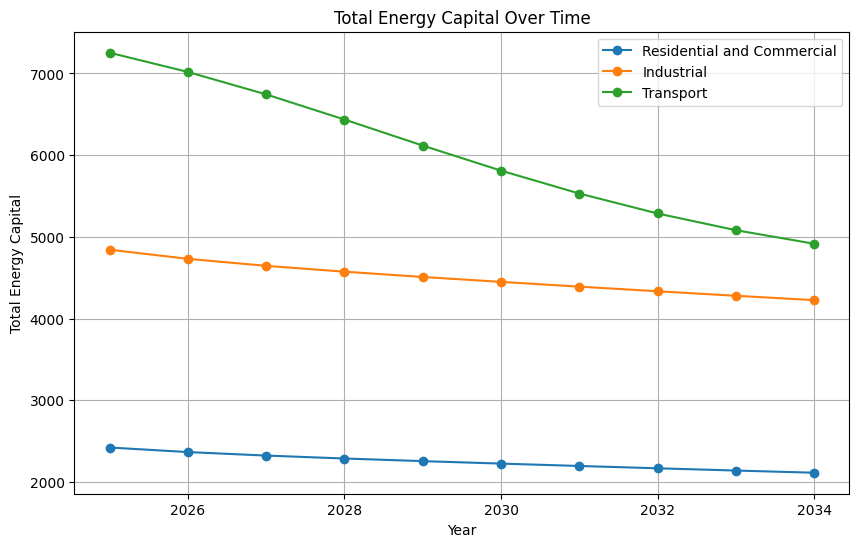

**Conceptual Meaning**
This equation measures how far the current tech effect rate is from the expected energy efficiency improvements.
Before the start year (e.g., 2025), it assumes a reference improvement rate. After that, it switches to a different expected improvement.
The result is a gap that indicates how much improvement is still needed to reach the expected energy efficiency levels.

The TechEffectModel should output the **Tech effect rate relative to target** by integrating the change in tech over time. This is done by multiplying the tech effect rate adjustment for each end use by the tech effect rat ratio of each enduse.
The tech adjustment rate is calculated by dividing the Tech effect rate gap by the time it takes to reach the long term intensity rate

The tech effect rate Gap is The gap between the GDP/capita rate target and actual, as a fraction of the actual calculated by selecting one of the improvement rate inputs based on year that number is divided by the rate of decreac in a current year minus the tech effect rate ratio which is the gap beterrn the expected improvement and actural

**Output**
This code give a list of year and relative Tech Gap rate by sector (Transportation and stationary)

**Future Use**
this gets plugged into the energy consuming capital or energy reqirements section

In [ ]:
class TechEffectModel:
    def __init__(self, sector, start_year, ref_annual_improvement, annual_improvement, ei_improvement_rate, time_to_reach_long_term_rate):
        self.sector = sector
        self.start_year = start_year
        self.ref_annual_improvement = ref_annual_improvement
        self.annual_improvement = annual_improvement
        self.ei_improvement_rate = ei_improvement_rate
        self.time_to_reach_long_term_rate = time_to_reach_long_term_rate
        self.tech_effect_rate_ratio = 1  # Initial condition

    def zidz(self, numerator, denominator):
        return numerator / denominator if denominator != 0 else 0 #(a function from endroads that says the answer is zero if divided by zero)

    def rate_of_decrease(self, time):
        return self.ei_improvement_rate #This equation determines the rate at which energy intensity (energy consumption per unit of output) decreases over time. #seems like it just returns the same thing no matter what But it hink we will adjust this value in other sections of the module making this dynamic

    def tech_effect_rate_gap(self, time):
        improvement_rate = self.ref_annual_improvement if time < self.start_year else self.annual_improvement
        return self.zidz(improvement_rate / self.rate_of_decrease(time) - self.tech_effect_rate_ratio, self.tech_effect_rate_ratio) #this is the Heart

    def tech_effect_rate_adjustment(self, time):
        return self.tech_effect_rate_gap(time) / self.time_to_reach_long_term_rate #Tech effect rate adjustment[EndUseSector] = Tech effect rate Gap[EndUseSector] / Time to reach long term intensity rate

    def change_in_tech_effect_rate(self, time):
        if time <= 2021:
            return 0
        return self.tech_effect_rate_adjustment(time) * self.tech_effect_rate_ratio #IF THEN ELSE( Time <= y2021, 0, Tech effect rate adjustment[EndUseSector] * Tech effect rate ratio[EndUseSector] )

    def update_tech_effect_rate_ratio(self, time):
        self.tech_effect_rate_ratio += self.change_in_tech_effect_rate(time)

    def simulate(self, time_steps):
        results = []
        for time in time_steps:
            self.update_tech_effect_rate_ratio(time)
            results.append((time, self.tech_effect_rate_ratio))
        return results

# Example Usage
if __name__ == "__main__":
    stationary_sector = TechEffectModel(
        sector="stationary",
        #params
        start_year=2025,
        ref_annual_improvement=1.2,
        annual_improvement=1.2,
        ei_improvement_rate=2.9, #could change to 1.7 or 1.8 not sure with documentation
        time_to_reach_long_term_rate=10
    )

    transport_sector = TechEffectModel(
        sector="transport",
        #params
        start_year=2025,
        ref_annual_improvement=1.2,
        annual_improvement=1.2,
        ei_improvement_rate=1.7,
        time_to_reach_long_term_rate=10
    )

    time_steps = range(2020, 2035)
    print(stationary_sector.simulate(time_steps))
    print(transport_sector.simulate(time_steps))

[(2020, 1), (2021, 1), (2022, 0.9413793103448276), (2023, 0.8886206896551724), (2024, 0.8411379310344828), (2025, 0.7984034482758621), (2026, 0.7599424137931035), (2027, 0.7253274827586207), (2028, 0.6941740448275862), (2029, 0.6661359506896551), (2030, 0.6409016659655172), (2031, 0.6181908097137931), (2032, 0.5977510390872414), (2033, 0.5793552455233448), (2034, 0.562799031315838)]
[(2020, 1), (2021, 1), (2022, 0.9705882352941176), (2023, 0.9441176470588235), (2024, 0.9202941176470588), (2025, 0.8988529411764706), (2026, 0.8795558823529412), (2027, 0.8621885294117648), (2028, 0.846557911764706), (2029, 0.832490355882353), (2030, 0.8198295555882353), (2031, 0.8084348353235294), (2032, 0.7981795870852941), (2033, 0.7889498636708824), (2034, 0.7806431125979117)]


**Complementary assets**
based on the number of installs this is the value of complementary assets such as charging or fueling stations

In [ ]:
import math
import pandas as pd

class ComplementaryAssets:
    def __init__(self, initial_assets, installation_capacity, k_soft, f_soft, v_soft):
        """
        Initialize the ComplementaryAssets class.

        Parameters:
        initial_assets (float): Initial complementary assets ($)
        installation_capacity (float): Complementary asset installation capacity ($/Year)
        k_soft (float): Soft limit parameter
        f_soft (float): Soft limit parameter
        v_soft (float): Soft limit parameter
        """
        self.complementary_assets = initial_assets
        self.installation_capacity = installation_capacity
        self.k_soft = k_soft
        self.f_soft = f_soft
        self.v_soft = v_soft

    def increase_in_complementary_assets(self, indicated_increase):
        """
        Calculate the annual increase in complementary assets using a fuzzy MIN function.

        Parameters:
        indicated_increase (float): Indicated increase in complementary assets ($/Year)

        Returns:
        float: Increase in complementary assets ($/Year)
        """
        if self.installation_capacity <= 0:
            return 0

        fuzzy_min = (1 / (1 + self.k_soft * math.exp(-self.f_soft * (indicated_increase / self.installation_capacity)))) ** self.v_soft

        return max(0, self.installation_capacity * fuzzy_min)

    def update_complementary_assets(self, indicated_increase, time_step):
        """
        Update the complementary assets over time.

        Parameters:
        indicated_increase (float): Indicated increase in complementary assets ($/Year)
        time_step (float): Time step for integration (Years)

        Returns:
        float: Updated complementary assets ($)
        """
        increase = self.increase_in_complementary_assets(indicated_increase)
        self.complementary_assets += increase * time_step
        return self.complementary_assets

# Parameters
initial_assets = 10000
installation_capacity = 5000
k_soft = 2  # from Enroads
f_soft = 4  # from Enroads
v_soft = 3  # from Enroads
time_step = 1  # Each step is 1 year
indicated_increase = 1000
years = 10
start_year = 2025

# Initialize model
assets_model = ComplementaryAssets(initial_assets, installation_capacity, k_soft, f_soft, v_soft)

# Track complementary assets over time
data = []

for year in range(start_year, start_year + years):
    updated_assets = assets_model.update_complementary_assets(indicated_increase, time_step)
    data.append({"Year": year, "Complementary Assets ($)": updated_assets})

# Create DataFrame
df_assets = pd.DataFrame(data)

# Display DataFrame
print(df_assets)




   Year  Complementary Assets ($)
0  2025              10730.516152
1  2026              11461.032305
2  2027              12191.548457
3  2028              12922.064609
4  2029              13652.580762
5  2030              14383.096914
6  2031              15113.613067
7  2032              15844.129219
8  2033              16574.645371
9  2034              17305.161524


In [ ]:
#Archive

In [ ]:
#this is Energy Consuming Capital
# I removed the vintage things as I dont understand them


class EnergyConsumingCapital1:
    def __init__(self, end_use_sectors, initial_capital, gdp_by_sector, capital_lifetime):
        """
        Initializes the model for energy-consuming capital in various end-use sectors.

        :param end_use_sectors: List of end-use sectors.
        :param initial_capital: Dictionary with initial capital for each sector.
        :param gdp_by_sector: Dictionary with GDP values for each sector.
        :param capital_lifetime: Dictionary with capital lifetime for each sector.
        """

        self.end_use_sectors = end_use_sectors
        self.capital = {sector: initial_capital.get(sector, 0) for sector in end_use_sectors} #get initial values that are inputs
        self.gdp_by_sector = gdp_by_sector
        self.capital_lifetime = capital_lifetime
        self.initial_capital_output_ratio = 2.5 #given in Enroads
        self.time_to_adjust = 1 #given in Enroads
        self.discarding_rate = {sector: min(1, max(0, 1 / (capital_lifetime[sector] / 3))) for sector in end_use_sectors}

    def desired_capital(self, sector):
        """Calculates the desired capital for a given sector."""
        return self.gdp_by_sector.get(sector, 0) * self.initial_capital_output_ratio #just gdp times intial capital output ratio given as 2.5

    def installing_capital(self, sector, total_energy_capital, discarded_retired_capital):
        """Calculates the new capital installations for a given sector."""
        return max(0, (self.desired_capital(sector) - total_energy_capital) / (self.time_to_adjust + discarded_retired_capital)) #max 0 or this number

    def discarding_capital_1(self, sector):
        """Calculates the discarding of capital in phase 1 due to cost increases."""
        return self.capital[sector] * self.discarding_rate[sector] #

    def retiring_capital(self, sector):
        """Calculates the discarding of capital in phase 1 due to cost increases."""
        return self.capital[sector] * self.discarding_rate[sector] #

    def discarded_and_retired_capital(self, sector, retiring):
        """Calculates the total discarded and retired capital for a given sector."""
        return retiring + self.discarding_capital_1(sector)  #retiring is a given...

    def update_capital(self, sector, retiring, total_energy_capital):
        """Updates the energy-consuming capital for a given sector."""
        discarded_retired = self.discarded_and_retired_capital(sector, retiring)
        new_installations = self.installing_capital(sector, total_energy_capital, discarded_retired)
        self.capital[sector] += new_installations - discarded_retired

    def get_capital(self, sector):
        """Returns the current energy-consuming capital for a given sector."""
        return self.capital.get(sector, 0)

# Example Usage
end_use_sectors = ["Residential and Commercial", "Industrial", "Transport"] #the three groups
initial_capital = {"Residential and Commercial": 57, "Industrial": 50, "Transport": 20} #values from straight line in Enroads
gdp_by_sector = {"Residential and Commercial": 1000, "Industrial": 1500, "Transport": 20} #this comes from another module need to update #todo
capital_lifetime = {"Residential and Commercial": 30, "Industrial": 30,"Transport": 15} #straight lines in Enroads #each vintage has a different life time

model = EnergyConsumingCapital1(end_use_sectors, initial_capital, gdp_by_sector, capital_lifetime)

# Simulating an update
model.update_capital("Residential and Commercial", retiring=5, total_energy_capital=0) #retiring needs to be added
#total_energy_capital set randomly (do they want the value from each enduse so need to loop in each one?)
#(Total_energy_Capital loops on all others? Total energy consuming capital for each end use[EndUseSector]= Energy consuming capital 1[EndUseSector] + Energy consuming capital 2[EndUseSector]+ Energy consuming capital 3[EndUseSector]

print(model.get_capital("Residential and Commercial"))  # Updated capital value need to give they system what sector you want can change that in get_capital function


In [ ]:
class new_capital_tech_effect:
    def __init__(self, name, ei_improvement_rate, ref_annual_improvement):
        self.name = name
        self.ei_improvement_rate = ei_improvement_rate
        self.ref_annual_improvement = ref_annual_improvement
        self.tech_effect_rate_ratio = 1  # Initial value
        self.tech_effect_on_energy_intensity = 1  # Initial value
        self.start_year_intensity_improvement = 2025

    def rate_of_decrease_energy_intensity(self, time):
        return self.ei_improvement_rate * self.tech_effect_rate_ratio / 100

    def change_in_tech_effect_rate(self, time):
        if time <= 2021:
            return 0
        return self.tech_effect_rate_adjustment() * self.tech_effect_rate_ratio

    def tech_effect_rate_adjustment(self):
        return self.tech_effect_rate_gap() / 10  # Time to reach long-term intensity rate

    def tech_effect_rate_gap(self):
        if self.start_year_intensity_improvement > 2025:
            annual_improvement = self.ref_annual_improvement
        else:
            annual_improvement = self.ref_annual_improvement
        return (annual_improvement / self.rate_of_decrease_energy_intensity(2025)) - self.tech_effect_rate_ratio

    def decreasing_energy_requirements(self):
        min_value = min(
            self.tech_effect_on_energy_intensity * self.rate_of_decrease_energy_intensity(2025),
            max(0, self.tech_effect_on_energy_intensity / 1)  # One year = 1
        )
        return min_value

    def update_tech_effect(self):
        self.tech_effect_on_energy_intensity -= self.decreasing_energy_requirements()
        self.tech_effect_rate_ratio += self.change_in_tech_effect_rate(2025)

# Initialize sectors
residential = new_capital_tech_effect("Residential", 2.9, 1.2)
commercial = new_capital_tech_effect("Commercial", 1.7, 1.2)
industrial = new_capital_tech_effect("Industrial", 1.8, 0.5)

# Example simulation
for year in range(2025, 2035):
    print(f"Year: {year}")
    for sector in [residential, commercial, industrial]:
        sector.update_tech_effect()
        print(f"{sector.name} - New Capital Tech Effect on Energy Intensity: {sector.tech_effect_on_energy_intensity:.4f}")
    print("-")


In [ ]:
#code for stacked area graphs

import numpy as np
import matplotlib.pyplot as plt

class EnergyConsumingCapital:
    def __init__(self, sector, gdp_by_sector, gdp_rate_of_change):
        self.sector = sector
        self.gdp_by_sector = gdp_by_sector
        self.gdp_rate_of_change = gdp_rate_of_change
        self.initial_capital_output_ratio = 2.5
        self.capital_lifetime = {"Residential and Commercial": 30, "Industrial": 30, "Transport": 15}[sector]
        self.time_to_adjust = 5  # Assumed time for capital adjustment

        self.initialize_capital()

    def initialize_capital(self):
        self.initial_energy_consuming_capital = self.gdp_by_sector * self.initial_capital_output_ratio
        self.vintage_1_lifetime = self.capital_lifetime / 3
        self.vintage_2_lifetime = self.capital_lifetime / 3
        self.vintage_3_lifetime = self.capital_lifetime / 3

        self.relative_initial_capital_v1 = np.exp(-self.gdp_rate_of_change / 100 * self.vintage_1_lifetime)
        self.relative_initial_capital_v2 = np.exp(-self.gdp_rate_of_change / 100 * (self.vintage_1_lifetime + self.vintage_2_lifetime))
        self.relative_initial_capital_v3 = 1 - (self.relative_initial_capital_v1 + self.relative_initial_capital_v2)

        sum_relative_capital = self.relative_initial_capital_v1 + self.relative_initial_capital_v2 + self.relative_initial_capital_v3

        self.frac_initial_capital_v1 = self.relative_initial_capital_v1 / sum_relative_capital
        self.frac_initial_capital_v2 = self.relative_initial_capital_v2 / sum_relative_capital
        self.frac_initial_capital_v3 = self.relative_initial_capital_v3 / sum_relative_capital

        self.energy_capital_1 = self.initial_energy_consuming_capital * self.frac_initial_capital_v1
        self.energy_capital_2 = self.initial_energy_consuming_capital * self.frac_initial_capital_v2
        self.energy_capital_3 = self.initial_energy_consuming_capital * self.frac_initial_capital_v3

    def compute_total_energy_capital(self):
        return self.energy_capital_1 + self.energy_capital_2 + self.energy_capital_3

    def compute_installing_energy_capital(self):
        desired_capital = self.gdp_by_sector * self.initial_capital_output_ratio
        total_capital = self.compute_total_energy_capital()
        return max(0, (desired_capital - total_capital) / self.time_to_adjust)

    def update_capital(self):
        installing_capital = self.compute_installing_energy_capital()
        aging_1_to_2 = self.energy_capital_1 / self.vintage_1_lifetime
        discarding_1 = self.energy_capital_1 / self.vintage_1_lifetime

        self.energy_capital_1 += installing_capital - aging_1_to_2 - discarding_1
        self.energy_capital_2 += aging_1_to_2 - (self.energy_capital_2 / self.vintage_2_lifetime)
        self.energy_capital_3 += (self.energy_capital_2 / self.vintage_2_lifetime) - (self.energy_capital_3 / self.vintage_3_lifetime)

# Simulation setup
sectors = ["Residential and Commercial", "Industrial", "Transport"]
gdp_values = {"Residential and Commercial": 1000, "Industrial": 2000, "Transport": 3000}
gdp_growth_rate = 2  # Example rate of change

capital_models = {sector: EnergyConsumingCapital(sector, gdp_values[sector], gdp_growth_rate) for sector in sectors}

# Storing results for plotting
time_steps = 10
time_range = range(time_steps)
data = {sector: {"energy_capital_1": [], "energy_capital_2": [], "energy_capital_3": []} for sector in sectors}

for _ in time_range:
    for sector, model in capital_models.items():
        model.update_capital()
        data[sector]["energy_capital_1"].append(model.energy_capital_1)
        data[sector]["energy_capital_2"].append(model.energy_capital_2)
        data[sector]["energy_capital_3"].append(model.energy_capital_3)

# Plotting
fig, axes = plt.subplots(nrows=3, figsize=(8, 12), sharex=True)

for i, sector in enumerate(sectors):
    ax = axes[i]
    ax.stackplot(time_range,
                 data[sector]["energy_capital_1"],
                 data[sector]["energy_capital_2"],
                 data[sector]["energy_capital_3"],
                 labels=["Vintage 1", "Vintage 2", "Vintage 3"],
                 colors=["#1f77b4", "#ff7f0e", "#2ca02c"])
    ax.set_title(sector)
    ax.set_ylabel("Energy Capital")
    ax.legend(loc="upper left")

plt.xlabel("Time Steps")
plt.tight_layout()
plt.show()

In [ ]:
#formatted results with energy intensity incorporated

import numpy as np

class EnergyConsumingCapital:
    def __init__(self, sector, gdp_by_sector, gdp_rate_of_change):
        self.sector = sector
        self.gdp_by_sector = gdp_by_sector
        self.gdp_rate_of_change = gdp_rate_of_change
        self.initial_capital_output_ratio = 2.5
        self.capital_lifetime = {"Residential and Commercial": 30, "Industrial": 30, "Transport": 15}[sector]
        self.time_to_adjust = 5  # Assumed time for capital adjustment

        self.initialize_capital()

    def initialize_capital(self):
        self.initial_energy_consuming_capital = self.gdp_by_sector * self.initial_capital_output_ratio
        self.vintage_1_lifetime = self.capital_lifetime / 3 #10,10,5
        self.vintage_2_lifetime = self.capital_lifetime / 3
        self.vintage_3_lifetime = self.capital_lifetime / 3

        self.relative_initial_capital_v1 = np.exp(-self.gdp_rate_of_change / 100 * self.vintage_1_lifetime)
        self.relative_initial_capital_v2 = np.exp(-self.gdp_rate_of_change / 100 * (self.vintage_1_lifetime + self.vintage_2_lifetime))
        self.relative_initial_capital_v3 = 1 - (self.relative_initial_capital_v1 + self.relative_initial_capital_v2)

        sum_relative_capital = self.relative_initial_capital_v1 + self.relative_initial_capital_v2 + self.relative_initial_capital_v3

        self.frac_initial_capital_v1 = self.relative_initial_capital_v1 / sum_relative_capital
        self.frac_initial_capital_v2 = self.relative_initial_capital_v2 / sum_relative_capital
        self.frac_initial_capital_v3 = self.relative_initial_capital_v3 / sum_relative_capital

        self.energy_capital_1 = self.initial_energy_consuming_capital * self.frac_initial_capital_v1
        self.energy_capital_2 = self.initial_energy_consuming_capital * self.frac_initial_capital_v2
        self.energy_capital_3 = self.initial_energy_consuming_capital * self.frac_initial_capital_v3

        self.initial_effective_capital_age = (
            (self.energy_capital_1 * self.vintage_1_lifetime +
             self.energy_capital_2 * self.vintage_2_lifetime +
             self.energy_capital_3 * self.vintage_3_lifetime) /
            (self.energy_capital_1 + self.energy_capital_2 + self.energy_capital_3)
        )

    def compute_desired_capital(self):
        return self.gdp_by_sector * self.initial_capital_output_ratio

    def compute_total_energy_capital(self):
        return self.energy_capital_1 + self.energy_capital_2 + self.energy_capital_3

    def compute_installing_energy_capital(self):
        desired_capital = self.compute_desired_capital()
        total_capital = self.compute_total_energy_capital()
        return max(0, (desired_capital - total_capital) / self.time_to_adjust)

    def update_capital(self):
        installing_capital = self.compute_installing_energy_capital()
        aging_1_to_2 = self.energy_capital_1 / self.vintage_1_lifetime
        discarding_1 = self.energy_capital_1 / self.vintage_1_lifetime

        self.energy_capital_1 += installing_capital - aging_1_to_2 - discarding_1
        self.energy_capital_2 += aging_1_to_2 - (self.energy_capital_2 / self.vintage_2_lifetime)
        self.energy_capital_3 += (self.energy_capital_2 / self.vintage_2_lifetime) - (self.energy_capital_3 / self.vintage_3_lifetime)

    def compute_reference_energy_intensity(self, initial_energy_requirements, historic_rate_of_decrease):
        return (sum(initial_energy_requirements) / self.initial_energy_consuming_capital *
                np.exp(-historic_rate_of_decrease / 100 * self.initial_effective_capital_age))

    def __repr__(self):
        return (f"Sector: {self.sector}\n"
                f"Total Energy Capital: {self.compute_total_energy_capital():.2f}\n"
                f"Energy Capital 1: {self.energy_capital_1:.2f}, "
                f"Energy Capital 2: {self.energy_capital_2:.2f}, "
                f"Energy Capital 3: {self.energy_capital_3:.2f}\n")

# Example Usage
if __name__ == "__main__":
    sectors = ["Residential and Commercial", "Industrial", "Transport"]
    gdp_values = {"Residential and Commercial": 1000, "Industrial": 2000, "Transport": 3000} #will be inputs from GDP module
    gdp_growth_rate = 2  # Example rate of change
    historic_rates = {"Residential and Commercial": 0.9, "Industrial": 0.9, "Transport": -0.5}
    initial_energy_requirements = {"Residential and Commercial": [500], "Industrial": [1000], "Transport": [1500]}

    capital_models = {sector: EnergyConsumingCapital(sector, gdp_values[sector], gdp_growth_rate) for sector in sectors}

    for _ in range(10):  # Simulating 10 time steps
        for sector, model in capital_models.items():
            model.update_capital()
            ref_energy_intensity = model.compute_reference_energy_intensity(initial_energy_requirements[sector], historic_rates[sector])
            print(model)
            print(f"Reference Energy Intensity for {sector}: {ref_energy_intensity:.2f}\n")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class EnergyConsumingCapital:
    def __init__(self, sector, gdp_by_sector, gdp_rate_of_change):
        self.sector = sector
        self.gdp_by_sector = gdp_by_sector
        self.gdp_rate_of_change = gdp_rate_of_change
        self.initial_capital_output_ratio = 2.5 #this value will change by carrier and sector

#(coal, Residential and Commercial = 2) (coal, Industrial = 4) (coal, Transport = 0)#
# (oil, Residential and Commercial = 5.5) (oil, Industrial = 3.8) (oil, Transport = 8.2)
# (gas, Residential and Commercial = 6) (gas, Industrial = 4.5) (gas, Transport = 0.2)
# (bio, Residential and Commercial = 8) (bio, Industrial = 1.2) (bio, Transport = 0)
# (electric, Residential and Commercial = 4.2) (electric, Industrial = 5.2) (electric, Transport = 0.2)

        self.capital_lifetime = {"Residential and Commercial": 30, "Industrial": 30, "Transport": 15}[sector]
        self.time_to_adjust = 5
        self.initialize_capital()

    def initialize_capital(self):
        self.initial_energy_consuming_capital = self.gdp_by_sector * self.initial_capital_output_ratio
        self.vintage_1_lifetime = self.capital_lifetime / 3
        self.vintage_2_lifetime = self.capital_lifetime / 3
        self.vintage_3_lifetime = self.capital_lifetime / 3

        self.relative_initial_capital_v1 = np.exp(-self.gdp_rate_of_change / 100 * self.vintage_1_lifetime)
        self.relative_initial_capital_v2 = np.exp(-self.gdp_rate_of_change / 100 * (self.vintage_1_lifetime + self.vintage_2_lifetime))
        self.relative_initial_capital_v3 = 1 - (self.relative_initial_capital_v1 + self.relative_initial_capital_v2)

        sum_relative_capital = self.relative_initial_capital_v1 + self.relative_initial_capital_v2 + self.relative_initial_capital_v3

#Done by sector carrier is not a factor
        self.frac_initial_capital_v1 = self.relative_initial_capital_v1 / sum_relative_capital
        self.frac_initial_capital_v2 = self.relative_initial_capital_v2 / sum_relative_capital
        self.frac_initial_capital_v3 = self.relative_initial_capital_v3 / sum_relative_capital

        self.energy_capital_1 = self.initial_energy_consuming_capital * self.frac_initial_capital_v1
        self.energy_capital_2 = self.initial_energy_consuming_capital * self.frac_initial_capital_v2
        self.energy_capital_3 = self.initial_energy_consuming_capital * self.frac_initial_capital_v3

    def compute_total_energy_capital(self):
        return self.energy_capital_1 + self.energy_capital_2 + self.energy_capital_3

    def compute_installing_energy_capital(self):
        desired_capital = self.gdp_by_sector * self.initial_capital_output_ratio
        total_capital = self.compute_total_energy_capital()
        return max(0, (desired_capital - total_capital) / self.time_to_adjust)

    def update_capital(self):
        installing_capital = self.compute_installing_energy_capital()
        aging_1_to_2 = self.energy_capital_1 / self.vintage_1_lifetime
        discarding_1 = self.energy_capital_1 / self.vintage_1_lifetime

        self.energy_capital_1 += installing_capital - aging_1_to_2 - discarding_1
        self.energy_capital_2 += aging_1_to_2 - (self.energy_capital_2 / self.vintage_2_lifetime)
        self.energy_capital_3 += (self.energy_capital_2 / self.vintage_2_lifetime) - (self.energy_capital_3 / self.vintage_3_lifetime)

# Params
sectors = ["Residential and Commercial", "Industrial", "Transport"]
gdp_values = {"Residential and Commercial": 1000, "Industrial": 2000, "Transport": 3000} #pull real gdp values
gdp_growth_rate = 2 #pull real

capital_models = {sector: EnergyConsumingCapital(sector, gdp_values[sector], gdp_growth_rate) for sector in sectors}

# Simulating 10 time steps (years)
time_steps = 10
start_year = 2025
years = list(range(start_year, start_year + time_steps))

results = {"Year": years}
for sector in sectors:
    results[sector] = []

for _ in range(time_steps):
    for sector, model in capital_models.items():
        model.update_capital()
        results[sector].append(model.compute_total_energy_capital())

# Create DataFrame
df_results = pd.DataFrame(results)
print(df_results)

# Plot results
plt.figure(figsize=(10, 6))
for sector in sectors:
    plt.plot(df_results["Year"], df_results[sector], label=sector, marker='o')

plt.xlabel("Year")
plt.ylabel("Total Energy Capital")
plt.title("Total Energy Capital Over Time")
plt.legend()
plt.grid(True)
plt.show()

#explict oiler integrater

#1 fixGDP inputs
# 2 make it so it works with multiple fuel types
# find inputs for each fuel type
# seehow each fuel type is different
#compare results

installing energy consuming capital[EndUseSector,Carrier]
 =
Normal desired new capital[EndUseSector]
 *
Price effect of capital and energy costs on energy intensity[Carrier, EndUseSector]

Price effect of capital and energy costs on energy intensity[EndUseSector,Carrier]
 =
SMOOTH(
Price effect of energy costs on energy intensity[Carrier, EndUseSector]
 *
Price effect of capital costs on energy intensity[Carrier, EndUseSector]
,
Time for price effect
 )
 self.time_to_adjust = 5
 Price effect of energy costs on energy intensity[EndUseSector,Carrier]
 =
MAX( 0, 1 −
Reference long term demand elasticity of energy costs
 * ( ZIDZ(
Market price of energy to consumer[Carrier, EndUseSector]
,
Initial market price by carrier[Carrier, EndUseSector]
 ) − 1 ) )
 Reference long term demand elasticity of energy costs
 =
0.3
Market price of electricity
#(coal, Residential and Commercial = 5) (coal, Industrial = 5) (coal, Transport = 5)#
# (oil, Residential and Commercial = 20) (oil, Industrial = 40) (oil, Transport = 30)
# (gas, Residential and Commercial = 15) (gas, Industrial = 5) (gas, Transport = 5)
# (bio, Residential and Commercial = 17) (bio, Industrial = 20) (bio, Transport = 25)
# (electric, Residential and Commercial = 20) (electric, Industrial = 20) (electric, Transport = 20)

Initial market price by carrier[Carrier, EndUseSector]
#(coal, Residential and Commercial = 8) (coal, Industrial = 8) (coal, Transport = 8)#
# (oil, Residential and Commercial = 14) (oil, Industrial = 33) (oil, Transport = 22)
# (gas, Residential and Commercial = 12) (gas, Industrial = 8) (gas, Transport = 8)
# (bio, Residential and Commercial = 13) (bio, Industrial = 20) (bio, Transport = 20)
# (electric, Residential and Commercial = 30) (electric, Industrial = 30) (electric, Transport = 30)

Price effect of capital costs on energy intensity[EndUseSector,Carrier]
 =
0.1